In [179]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
normal_images = len(os.listdir('./Data/NORMAL'))
hemorrhagic_images = len(os.listdir('./Data/Hemorrhagic'))

print(f"Normal images: {normal_images}, Hemorrhagic images: {hemorrhagic_images}")

# Create the ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale image pixel values to [0, 1]
    validation_split=0.2,       # Validation split
    width_shift_range=0.2,      # Shift images horizontally by 20%
    height_shift_range=0.2,     # Shift images vertically by 20%
    rotation_range=40,          # Rotate images randomly up to 40 degrees
    zoom_range=0.2,             # Zoom in/out on images by 20%
    shear_range=0.2,            # Shear transformation up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill missing pixels after transformation
)

# Create the training generator (70% of data)
train_generator = datagen.flow_from_directory(
    './Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='training',      # Use the 'training' subset (70% of data)
    shuffle=True,  
    color_mode='grayscale'          # Shuffle training data
)

# Create the validation generator (30% of data)
validation_generator = datagen.flow_from_directory(
    './Data',              # Path to your dataset folder
    target_size=(128, 128),   # Resize images to this size
    batch_size=32,
    class_mode='binary',    # Use 'binary' or 'categorical' depending on your problem
    subset='validation',    # Use the 'validation' subset (30% of data)
    shuffle=False ,
    color_mode='grayscale'          # Don't shuffle validation data
)

Normal images: 4105, Hemorrhagic images: 2689
Found 5436 images belonging to 2 classes.
Found 1358 images belonging to 2 classes.


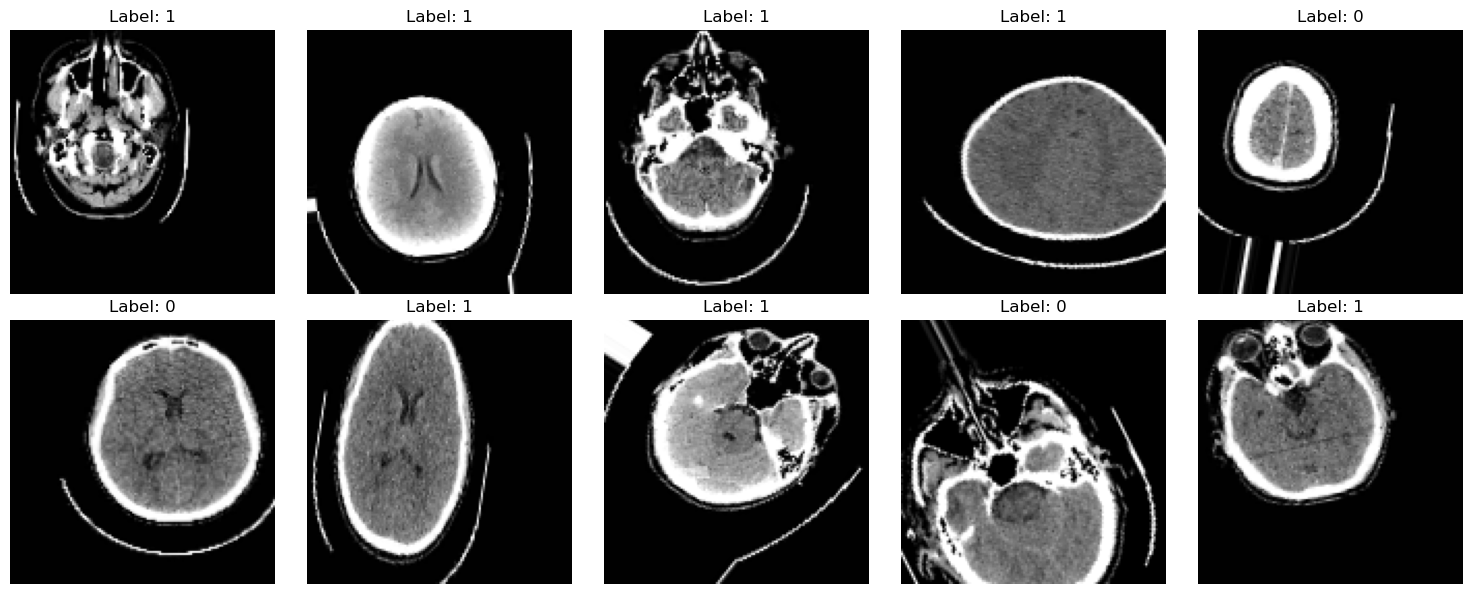

In [165]:
image, label = next(iter(train_generator))

import matplotlib.pyplot as plt

# Select the first 10 images and their labels
num_images = 10
images = image[:num_images]
labels = label[:num_images]

# Create a figure with 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust size as needed

# Flatten the axes for easy iteration
axes = axes.flatten()

for i in range(num_images):
    # Plot each image in a subplot
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray' if images[i].shape[-1] == 1 else None)
    ax.set_title(f"Label: {int(labels[i])}")
    ax.axis('off')  # Hide axis ticks

# Display the images
plt.tight_layout()
plt.show()

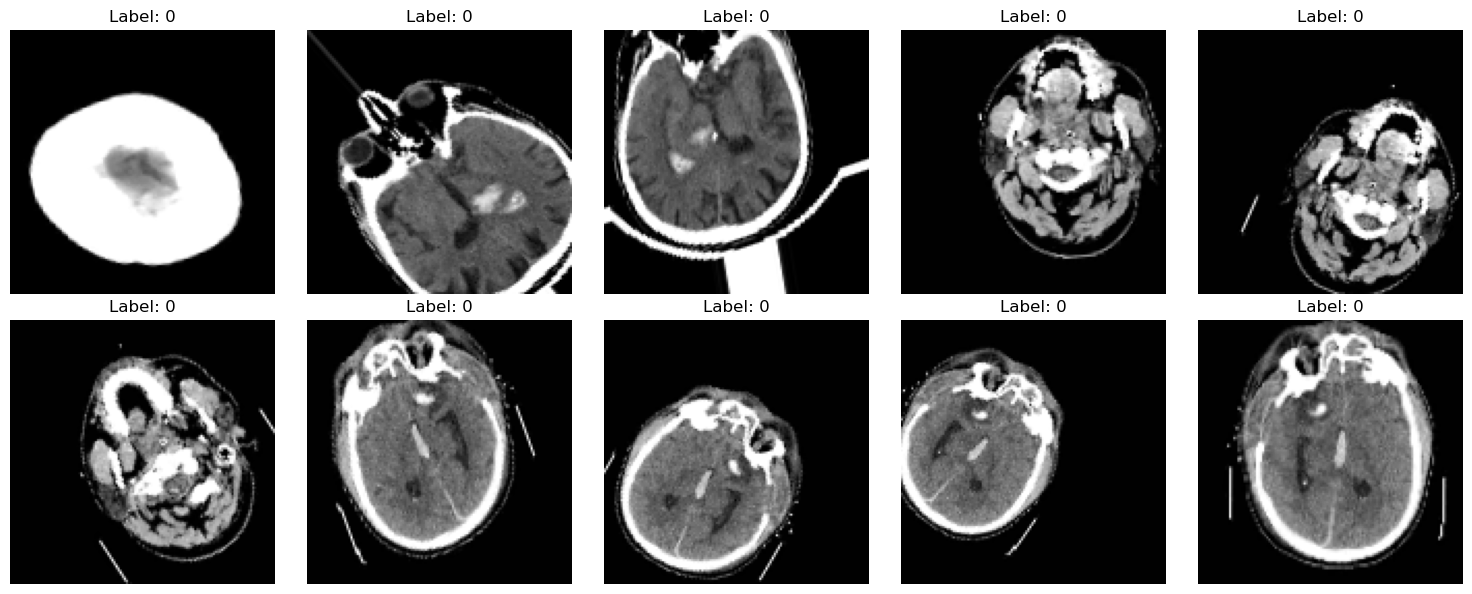

In [166]:
image, label = next(iter(validation_generator))



# Select the first 10 images and their labels
num_images = 10
images = image[:num_images]
labels = label[:num_images]

# Create a figure with 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Adjust size as needed

# Flatten the axes for easy iteration
axes = axes.flatten()

for i in range(num_images):
    # Plot each image in a subplot
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray' if images[i].shape[-1] == 1 else None)
    ax.set_title(f"Label: {int(labels[i])}")
    ax.axis('off')  # Hide axis ticks

# Display the images
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape, Dropout, BatchNormalization,Input, Permute, Multiply, Bidirectional
from tensorflow.keras.models import Model


# Define a custom attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Trainable weights
        self.W = self.add_weight(name="attention_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="attention_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Alignment scores
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        e = tf.keras.backend.squeeze(e, axis=-1)

        # Attention weights
        alpha = tf.keras.backend.softmax(e)
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)

        # Context vector
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)

        return context

# Define the LSTM model with attention
input_shape = (128, 128,1)  # Without channel

# Input layer
inputs = Input(shape=input_shape)

# Reshape input to include the channel dimension
reshaped = Reshape((128, 128))(inputs)

from tensorflow.keras.regularizers import l2

# LSTM layers
x = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01) )(reshaped)

x = Dropout(0.3)(x)
x = LSTM(64, activation='tanh', return_sequences=True,kernel_regularizer=l2(0.01))(x)

x = Dropout(0.3)(x)

# Attention mechanism
attention = Attention()(x)

# Fully connected layers
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(attention)
x = Dropout(.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(.3)(x)
# x = Dense(32, activation='relu')(x)

output = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(x)

# Define the model
model = Model(inputs, output)
# from tensorflow.keras.optimizers import Adam
# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=0.05),
#     loss='binary_crossentropy',  # Binary crossentropy for binary classification
#     metrics=['accuracy']
# )

# Print the model summary
model.summary()


# Evaluate the model
# loss, accuracy = model.evaluate(validation_generator)
# print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")



Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 128, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_14 (Attention)        │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,633 (740.75 KB)

 Trainable params: 189,633 (740.75 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Reshape,
    LSTM,
    Dense,
    Dropout,
    Input,
    BatchNormalization,
    Bidirectional,
)

# Input shape for grayscale images
input_shape = (224, 224, 1)
inputs = Input(shape=input_shape)

# CNN for feature extraction
x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)
# x = Flatten()(x)
print(x.shape)
# Reshape CNN output to sequence for RNN input
x = Reshape((-1,128))(x)

# BiLSTM layers
x = Bidirectional(LSTM(128, activation="tanh", return_sequences=False))(x)  # return_sequences=False for no attention
x = Dropout(0.5)(x)

# Fully connected layers
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation="sigmoid")(x)

# Define the model
model_no_attention = Model(inputs, output)

# Compile the model
model_no_attention.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Print the model summary
model_no_attention.summary()

(None, 28, 28, 128)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 784, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,057 (1.51 MB)

 Trainable params: 397,057 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',  # Binary crossentropy for binary classification
    metrics=['accuracy']
)
history = model.fit(
    train_generator,
    epochs=60 ,
    validation_data=validation_generator,
    # class_weight=class_weights
     callbacks=[lr_scheduler]
      # Number of epochs

)
from tensorflow.keras.models import load_model
model = model.save('my_model_1')

{0: 1.263011152416357, 1: 0.8276492082825823}
Epoch 1/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step - accuracy: 0.6073 - loss: 0.6703 - val_accuracy: 0.6046 - val_loss: 0.6711 - learning_rate: 0.0100
Epoch 2/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.6002 - loss: 0.6731 - val_accuracy: 0.6046 - val_loss: 0.6714 - learning_rate: 0.0100
Epoch 3/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.5840 - loss: 0.6809 - val_accuracy: 0.6046 - val_loss: 0.6715 - learning_rate: 0.0100
Epoch 4/60
 10/170 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.6341 - loss: 0.6575

KeyboardInterrupt: 

In [ ]:
Surprisingly, traditional machine learning methods performed better than expected, despite their inability to learn in the same way as neural networks.

In [ ]:
images, labels = next(iter(validation_generator))
images.shape
labels.shape

(32,)

In [198]:
history_dict = history.history

# Keys in the dictionary
print(history_dict.keys())  # Example: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# Access specific metrics
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

print("Training Loss:", training_loss[-1])
print("Validation Accuracy:", validation_accuracy[-1])
print('training accuracy:', training_accuracy[-1])
print(validation_loss[-1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Training Loss: 0.6713835597038269
Validation Accuracy: 0.6045655608177185
training accuracy: 0.604120671749115
0.6711313128471375


In [ ]:
loss, accuracy = model.evaluate(validation_generator)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.2656 - loss: 1.0973


In [ ]:
accuracy

0.561855673789978

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step


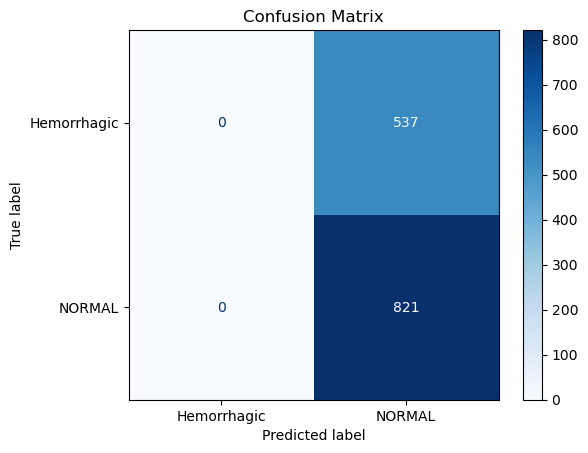

In [178]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int32")  # Convert probabilities to binary classes

# Get true labels from the validation generator
true_labels = validation_generator.classes
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

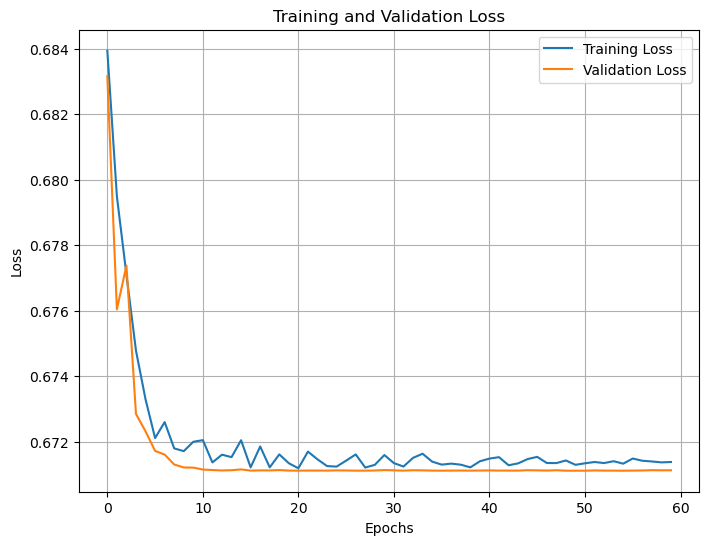

In [193]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

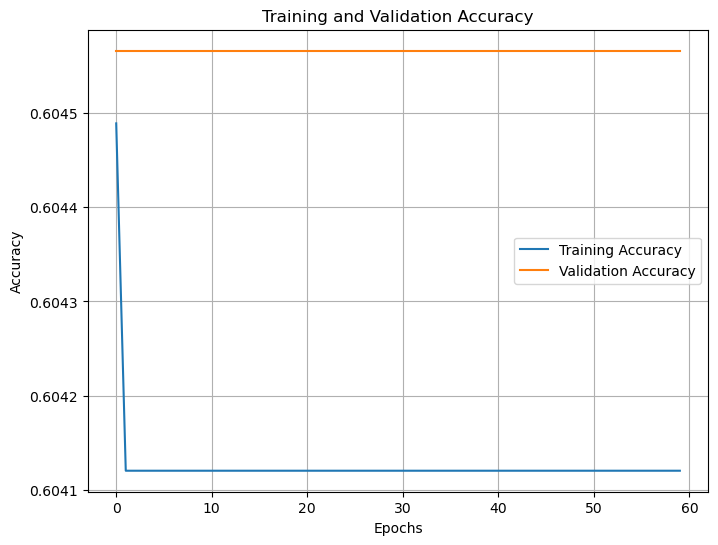

In [177]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
The first component of the model consists of two LSTM layers, each using a tanh activation function, a kernel regularizer (0.01), and followed by a dropout layer with a dropout rate of 0.3. After the second LSTM layer, an attention mechanism is applied to focus on the most relevant features.

The second component includes a dense layer with 128 units, a ReLU activation function, a kernel regularizer (0.01), and a dropout layer with a dropout rate of 0.3.

In [199]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Step 1: Get predictions
y_pred = model.predict(validation_generator)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Step 2: Get true labels
y_true = validation_generator.classes  # True labels from the generator

# Step 3: Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_binary, target_names=['Class 0', 'Class 1']))

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Precision: 0.6046
Recall: 1.0000
F1 Score: 0.7536

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       537
     Class 1       0.60      1.00      0.75       821

    accuracy                           0.60      1358
   macro avg       0.30      0.50      0.38      1358
weighted avg       0.37      0.60      0.46      1358



c:\Users\sebas\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sebas\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sebas\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

"Due to the unbalanced class distribution and the subtle differences between the classes, "
"the model struggled to distinguish them, resulting in overfitting on the normal class. "
"This is evident from the confusion matrix and the trends observed in the validation loss plot."